In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from scipy.ndimage import gaussian_filter

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,kpss







plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# EDA

## Data Loading

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')

In [7]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# function to rename columns in lower case
def lower_case(dataframe):
    cols = dataframe.columns.tolist()
    cols = [col.lower() for col in cols]
    dataframe.columns = cols
    return dataframe

In [42]:
lower_case(df_train);
lower_case(df_store);
lower_case(df_test);

In [10]:
# function to change date into datetime
def to_datetime(dataframe):
    dataframe.assign(
        timestamp = lambda x: pd.to_datetime(x['date']),
        year = lambda x: x['timestamp'].dt.year,
        month = lambda x: x['timestamp'].dt.month,
        day = lambda x: x['timestamp'].dt.day,
        dayofyear = lambda x: x['timestamp'].dt.dayofyear)
    return dataframe
# does not work :( 

In [11]:
#df_train = to_datetime(df_train)

In [13]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_train = df_train.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_train.drop("date", inplace=True, axis=1)

In [14]:
df_train.head()

,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear
0,1,5,5263,555,1,1,0,1,2015-07-31,2015,7,31,212
1,2,5,6064,625,1,1,0,1,2015-07-31,2015,7,31,212
2,3,5,8314,821,1,1,0,1,2015-07-31,2015,7,31,212
3,4,5,13995,1498,1,1,0,1,2015-07-31,2015,7,31,212
4,5,5,4822,559,1,1,0,1,2015-07-31,2015,7,31,212


In [26]:
print(df_store.shape)
df_store.head()

(1115, 10)


,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Data Cleaning

In [15]:
df_train.shape

(1017209, 13)

In [19]:
df_train['stateholiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [20]:
df_train.stateholiday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [21]:
df_train['stateholiday'].replace({0:'0'}, inplace=True)
round(df_train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
dayofweek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
schoolholiday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
year,1017209.0,2013.83,0.78,2013.0,2013.0,2014.0,2014.0,2015.0
month,1017209.0,5.85,3.33,1.0,3.0,6.0,8.0,12.0
day,1017209.0,15.70,8.79,1.0,8.0,16.0,23.0,31.0


### Cleaning NaN's

In [22]:
df_store.isnull().sum()

store                          0
storetype                      0
assortment                     0
competitiondistance            3
competitionopensincemonth    354
competitionopensinceyear     354
promo2                         0
promo2sinceweek              544
promo2sinceyear              544
promointerval                544
dtype: int64

In [27]:
df_store[pd.isnull(df_store.competitiondistance)]

,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [30]:
# fill NaN with a median value
df_store['competitiondistance'].fillna(df_store['competitiondistance'].median(), inplace = True)
df_store['competitiondistance'].isnull().sum()

0

In [31]:
tmp = df_store[pd.isnull(df_store.competitionopensinceyear)]
tmp[tmp.competitiondistance != 0].shape

(354, 10)

Here these stores have a competition in their vicinity ('competitiondistance' =/= 0), but there is no information about the year this competition has been open. This value needs to be imputed in a meaningful way. Or just filled with '0'.

In [34]:
tmp = df_store[pd.isnull(df_store.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 10)

There are no stores with information about 'promo2sinceweek' which have 'NaN' in promo2.

In [36]:
# replace NA's by 0
df_store.fillna(0, inplace = True)

In [62]:
print(df_store.isnull().sum())
print('------------------------')
print(df_train.isnull().sum())

store                        0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
dtype: int64
------------------------
store            0
dayofweek        0
sales            0
customers        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64


All the cleaning can also be done to the test dataset.

In [54]:
print(df_test.head())
print('------------------------------------------')
print(df_test.info())

   id  store  dayofweek  open  promo stateholiday  schoolholiday  timestamp  \
0   1      1          4   1.0      1            0              0 2015-09-17   
1   2      3          4   1.0      1            0              0 2015-09-17   
2   3      7          4   1.0      1            0              0 2015-09-17   
3   4      8          4   1.0      1            0              0 2015-09-17   
4   5      9          4   1.0      1            0              0 2015-09-17   

   year  month  day  dayofyear  
0  2015      9   17        260  
1  2015      9   17        260  
2  2015      9   17        260  
3  2015      9   17        260  
4  2015      9   17        260  
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             41088 non-null  int64         
 1   store          41

In [44]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_test = df_test.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_test.drop("date", inplace=True, axis=1)

In [57]:
print(df_test['stateholiday'].unique())
print(df_test['stateholiday'].value_counts())

['0' 'a']
0    40908
a      180
Name: stateholiday, dtype: int64


In [65]:
df_test[df_test["open"].isnull()]

,id,store,dayofweek,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear
479,480,622,4,NaN,1,0,0,2015-09-17,2015,9,17,260
1335,1336,622,3,NaN,1,0,0,2015-09-16,2015,9,16,259
2191,2192,622,2,NaN,1,0,0,2015-09-15,2015,9,15,258
3047,3048,622,1,NaN,1,0,0,2015-09-14,2015,9,14,257
4759,4760,622,6,NaN,0,0,0,2015-09-12,2015,9,12,255
5615,5616,622,5,NaN,0,0,0,2015-09-11,2015,9,11,254
6471,6472,622,4,NaN,0,0,0,2015-09-10,2015,9,10,253
7327,7328,622,3,NaN,0,0,0,2015-09-09,2015,9,9,252
8183,8184,622,2,NaN,0,0,0,2015-09-08,2015,9,8,251
9039,9040,622,1,NaN,0,0,0,2015-09-07,2015,9,7,250


All of these store have no information for 'open', although these days are not a holiday ('stateholiday =/= 1) and are not affected by the closure of schools. They should be open.

In [66]:
df_test['open'].fillna(1, inplace=True)
df_test['open']= df_test['open'].astype(int)

In [69]:
df_test.isnull().sum()

id               0
store            0
dayofweek        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64

## Data Exploration

In [84]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.store, right_on=df_store.store)
df.drop(['key_0', 'store_y'], axis=1, inplace=True)
df = df.rename(columns={'store_x':'store'})

In [85]:
df.groupby('storetype')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
storetype,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [86]:
df.groupby('storetype')['customers', 'sales'].sum()

,customers,sales
storetype,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


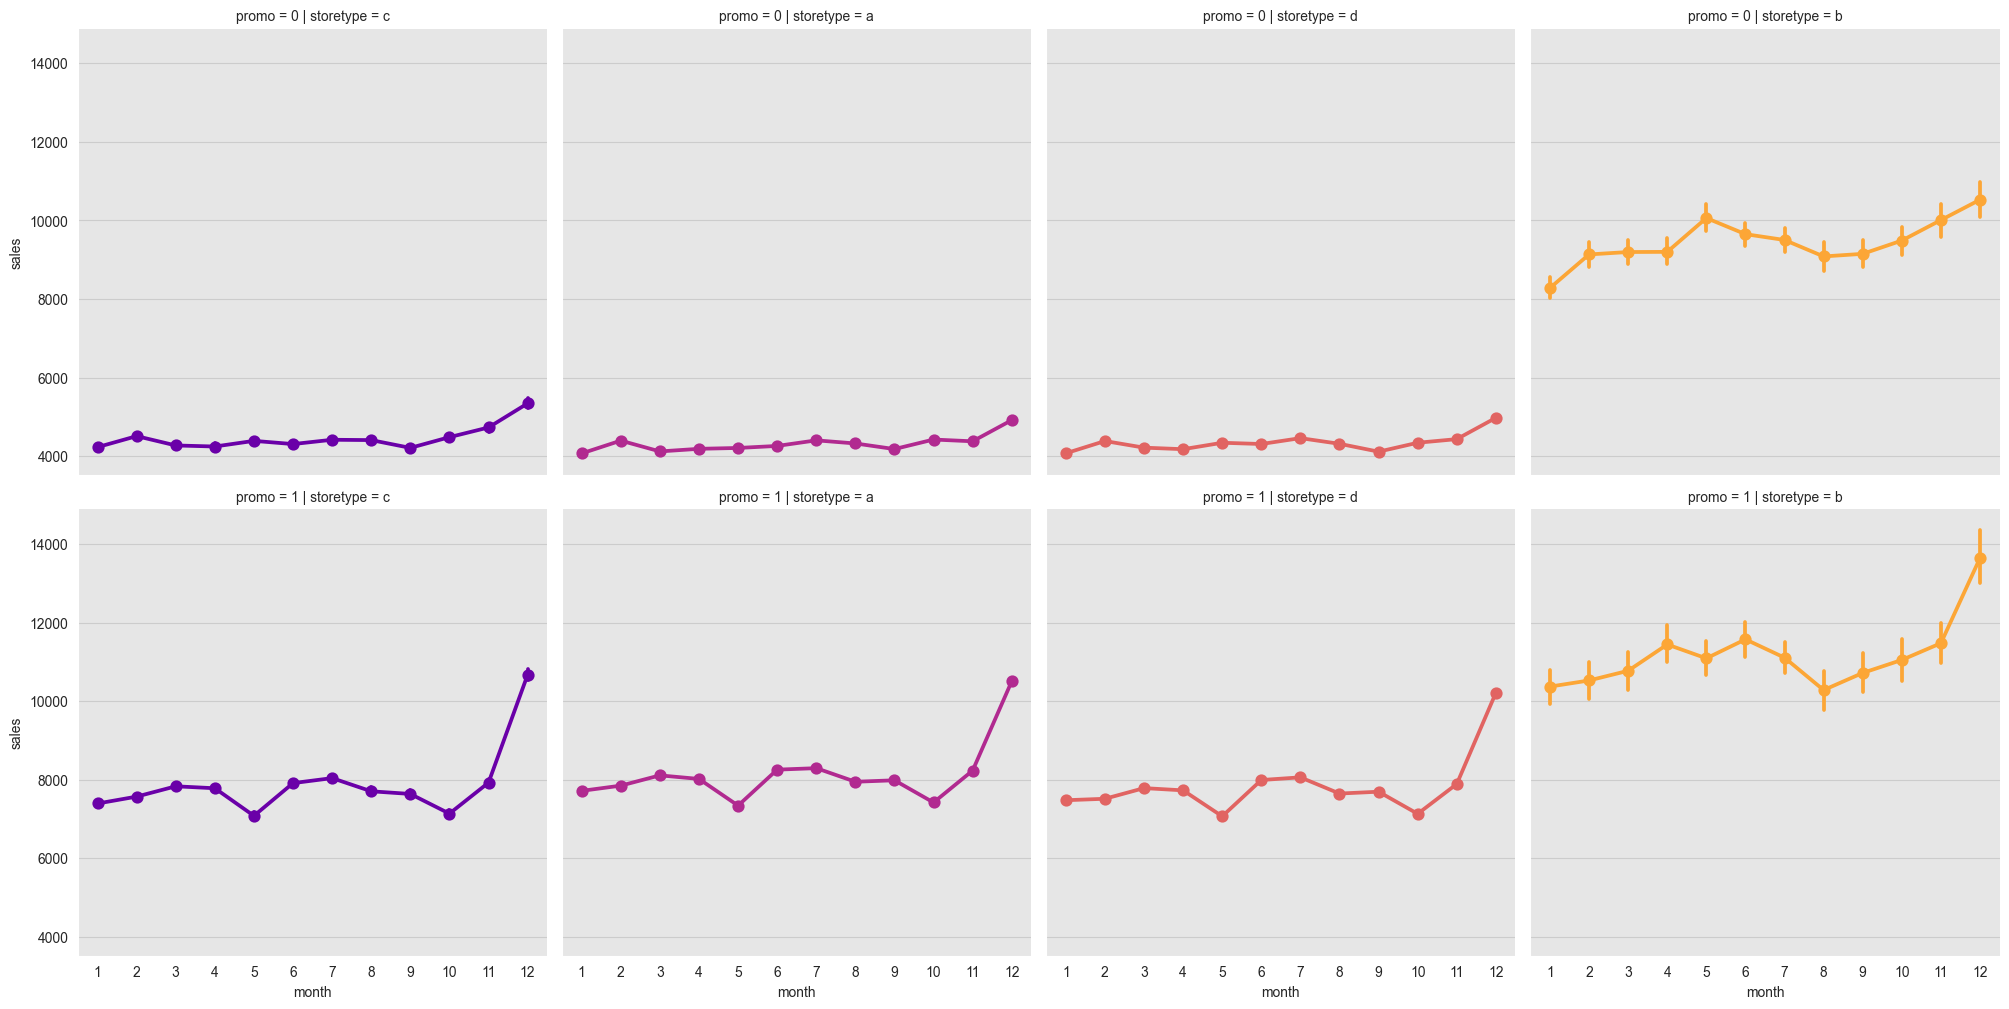

In [87]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

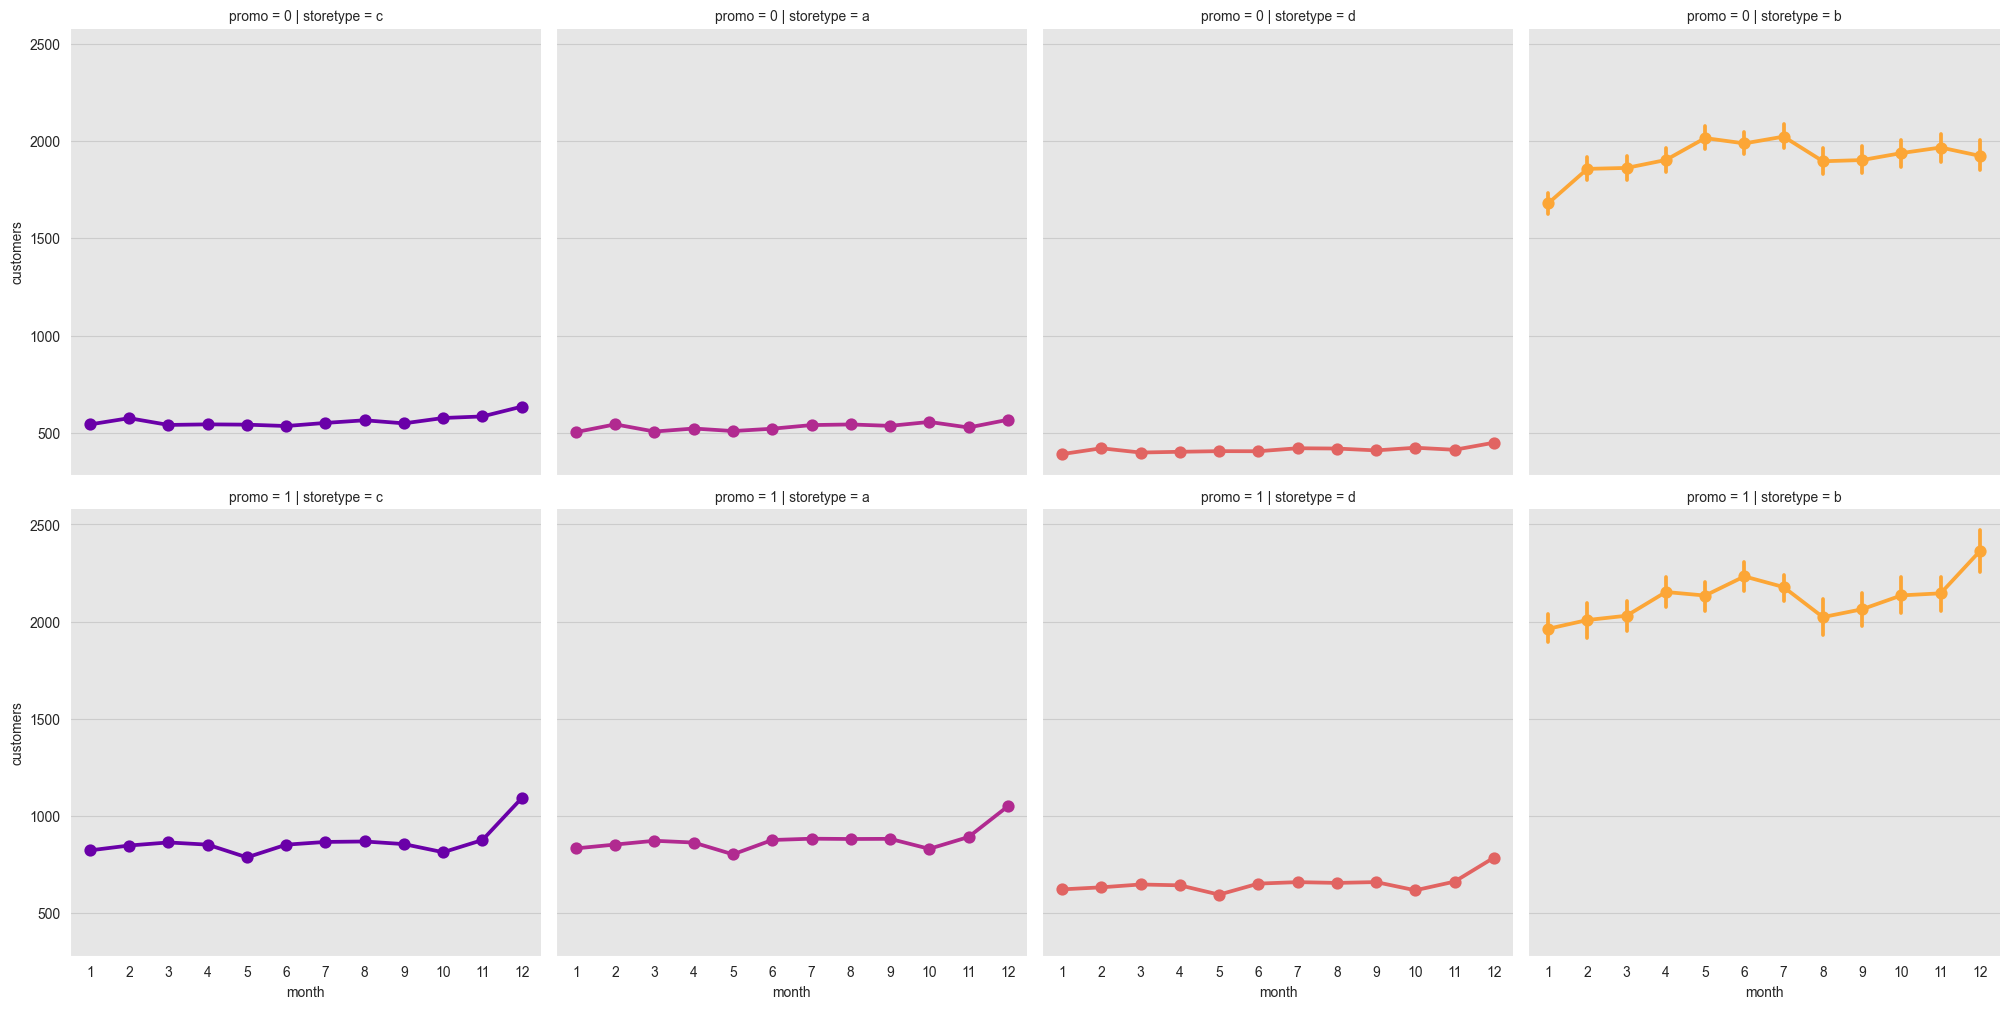

In [88]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

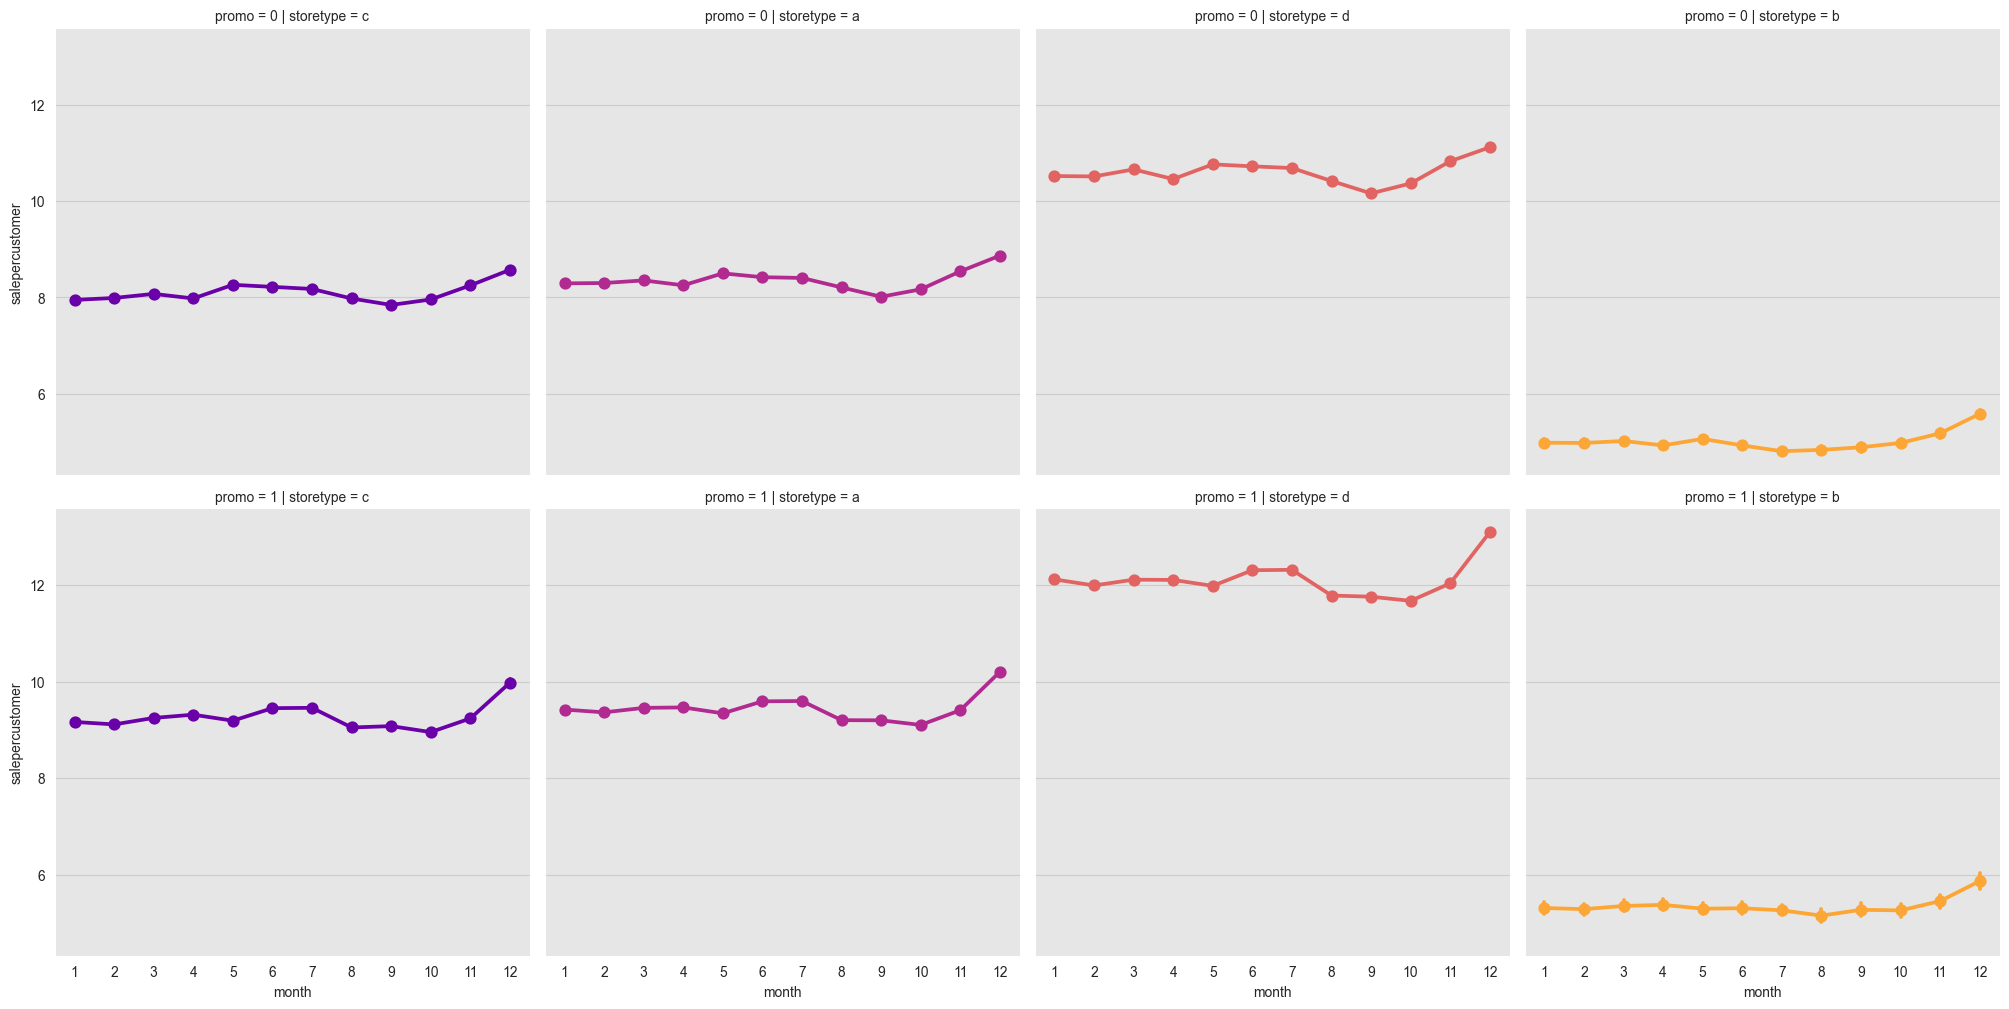

In [89]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

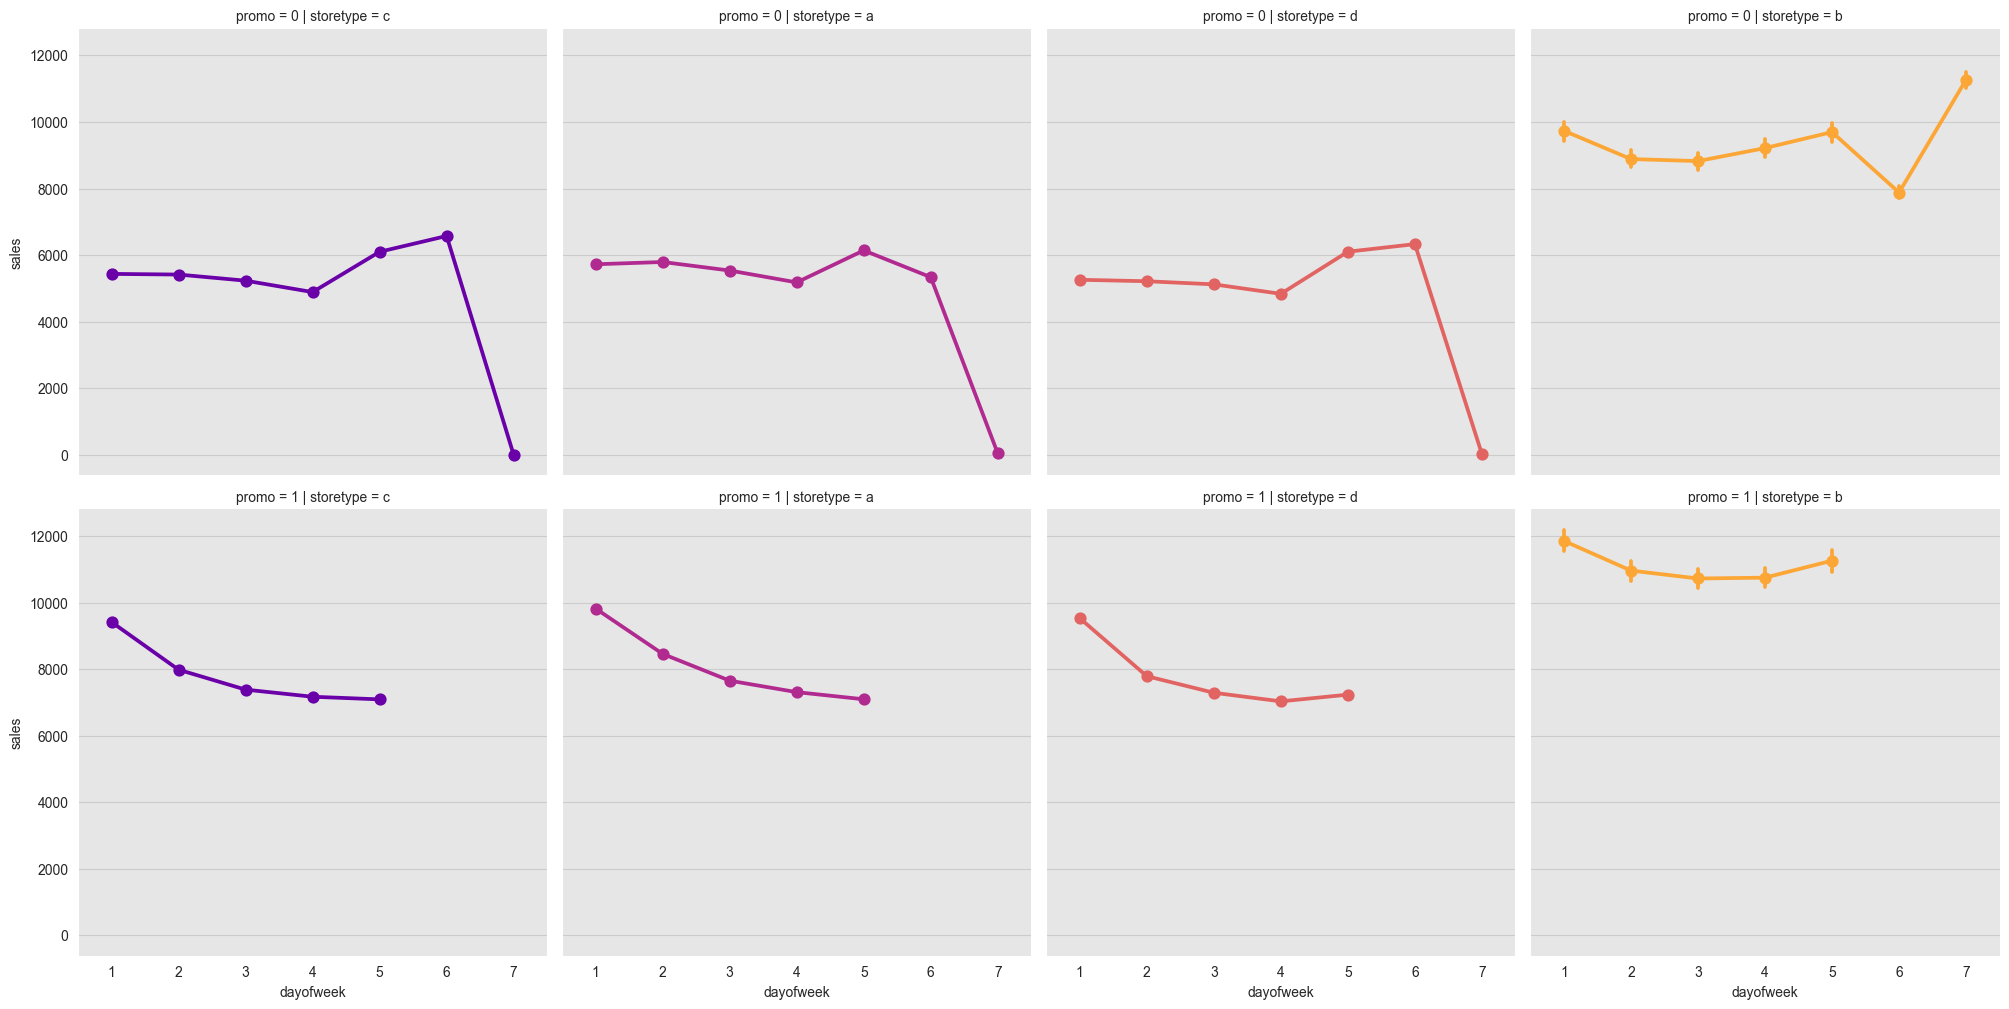

In [90]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

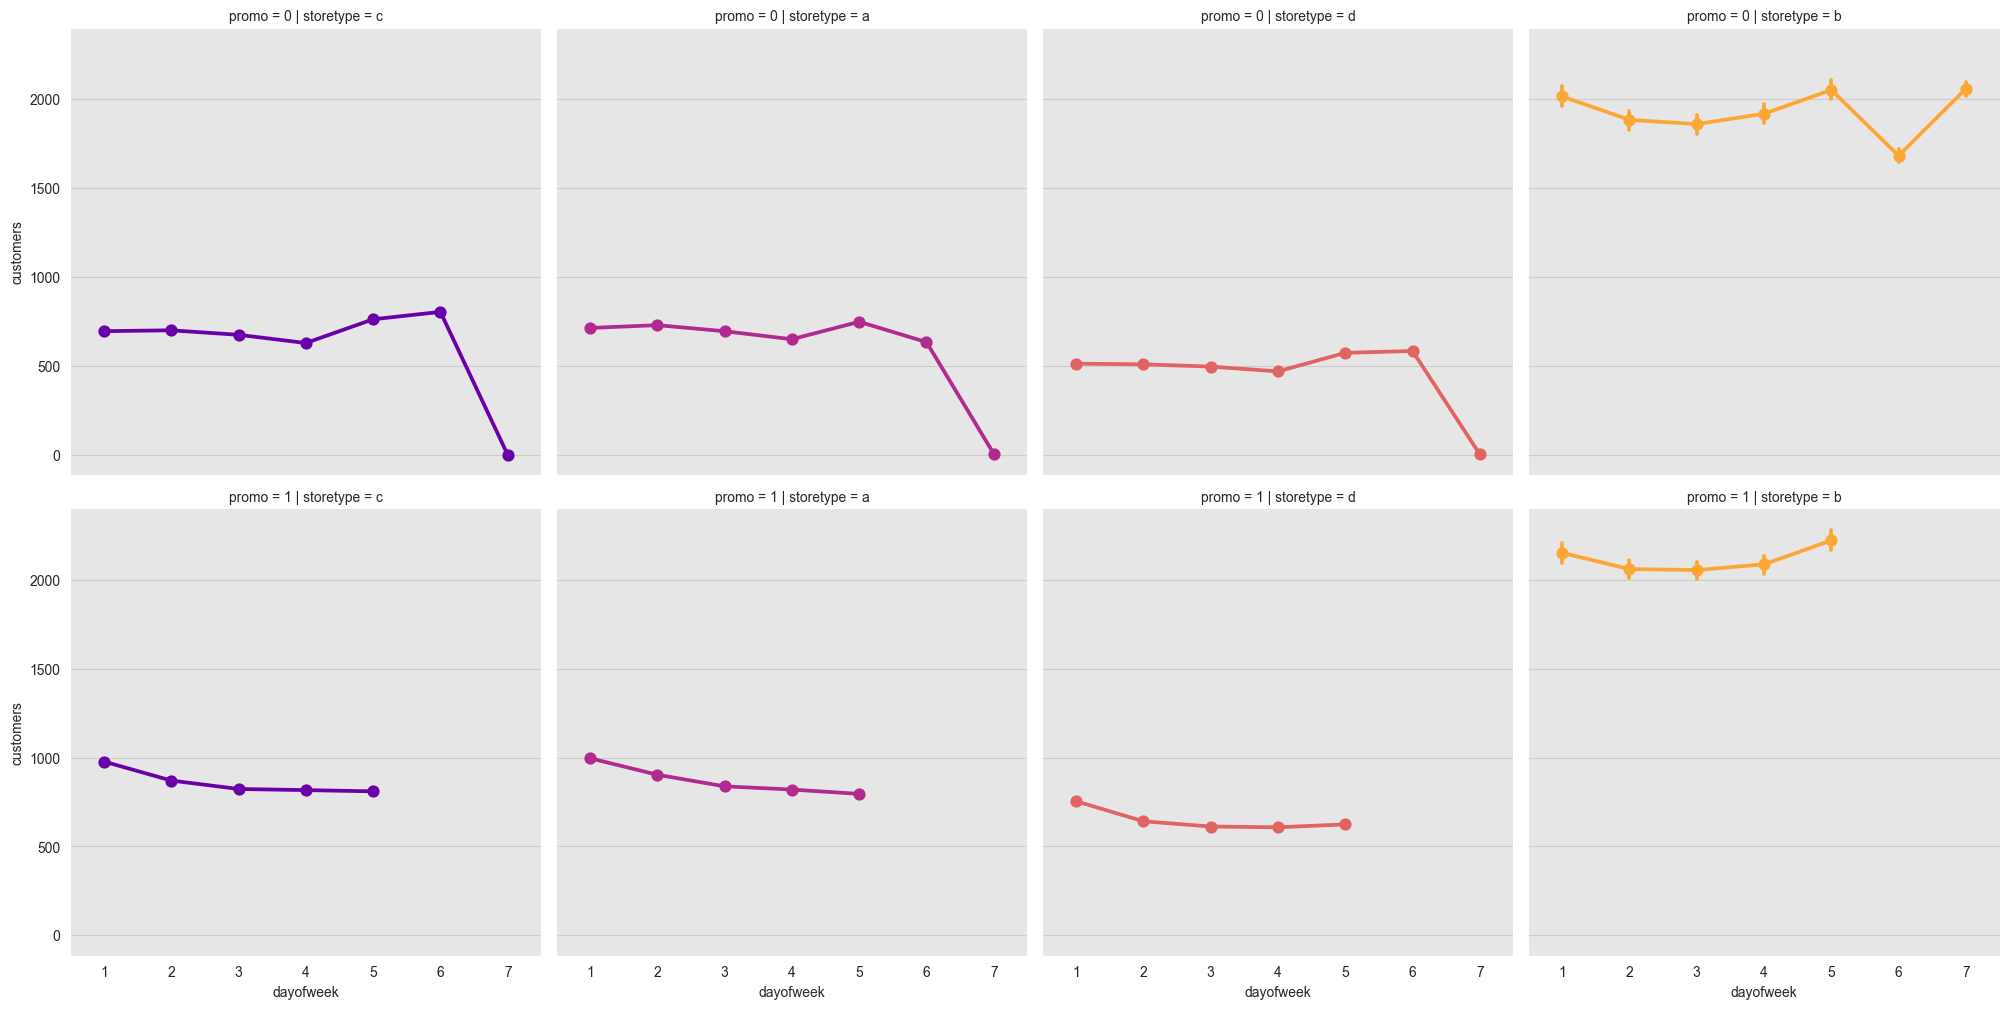

In [92]:
# weekday customer trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

### Conclusion:
- Promos are run only during the work-week, no promo on saturday/sunday\n",
- Storetype B has the highest number of customers, with the largest variance\n",
- Storetype B has the highest sales numbers, with the largest variance\n",
- All storetypes show increased sales numbers towards christmas\n",
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo."

In [102]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.00,838.0,1115.00
dayofweek,1017209.0,4.00,2.00,1.0,2.0,4.00,6.0,7.00
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.00,7856.0,41551.00
customers,1017209.0,633.15,464.41,0.0,405.0,609.00,837.0,7388.00
open,1017209.0,0.83,0.38,0.0,1.0,1.00,1.0,1.00
promo,1017209.0,0.38,0.49,0.0,0.0,0.00,1.0,1.00
schoolholiday,1017209.0,0.18,0.38,0.0,0.0,0.00,0.0,1.00
year,1017209.0,2013.83,0.78,2013.0,2013.0,2014.00,2014.0,2015.00
month,1017209.0,5.85,3.33,1.0,3.0,6.00,8.0,12.00
day,1017209.0,15.70,8.79,1.0,8.0,16.00,23.0,31.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

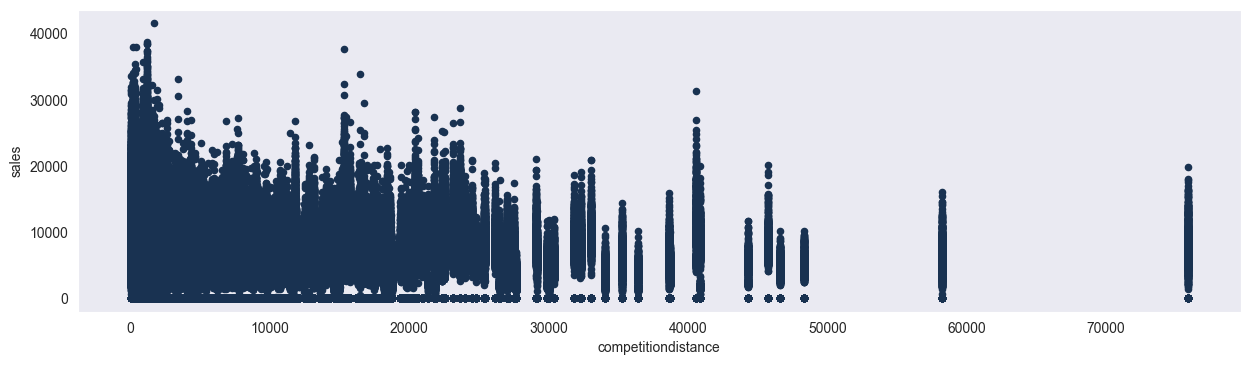

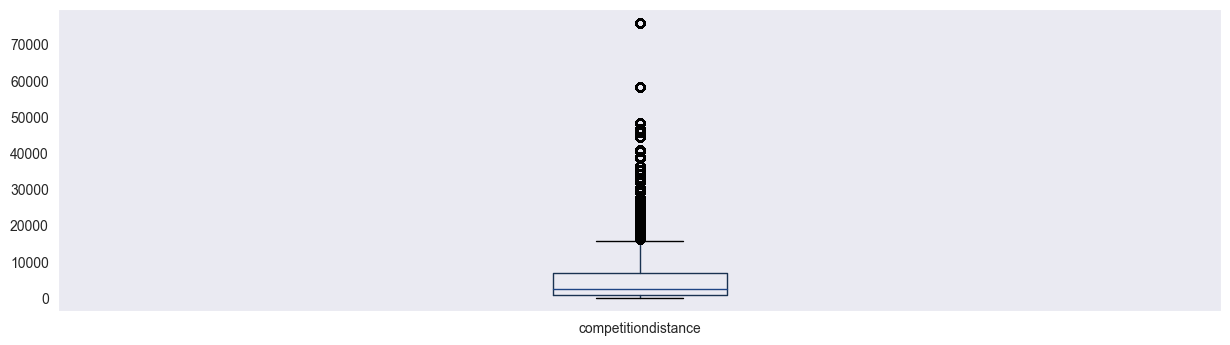

In [130]:
# Plot CompetitionDistance Vs Sales
df.plot(kind='scatter',x='competitiondistance',y='sales', figsize=(15,4))
df.plot(kind='box', y='competitiondistance', figsize=(15,4))

75% of all stores have their nearest competitor at under 7km distance, while 50% of all stores have their nearest competitor at 2.3km.

<AxesSubplot:xlabel='storetype', ylabel='competitiondistance'>

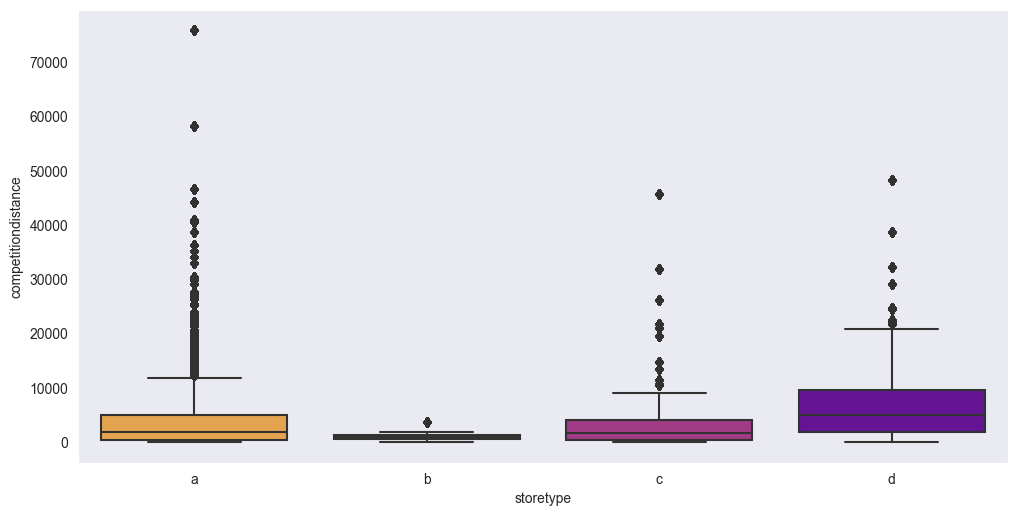

In [135]:
sns.boxplot(data= df, x= 'storetype', y= 'competitiondistance', palette = 'plasma_r', order=["a", "b", "c", "d"])

Storetype B has the nearest competitors, while storetyp D has the largest range and the largest mean distance. The farthest away competitors belong to Storetype A.

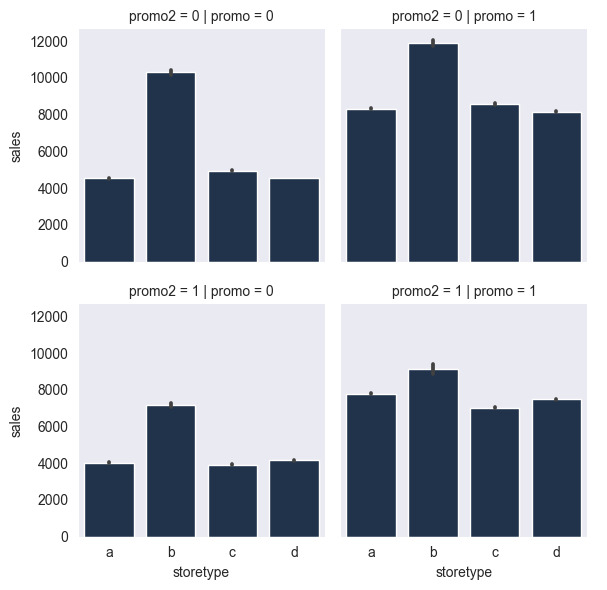

In [118]:
# plotting sales per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df,
                  col = 'promo',
                  row = 'promo2',
                  palette = 'plasma',
                  #hue = 'assortment',
                 )
g.map_dataframe(sns.barplot, "storetype", "sales", order=["a","b","c","d"])

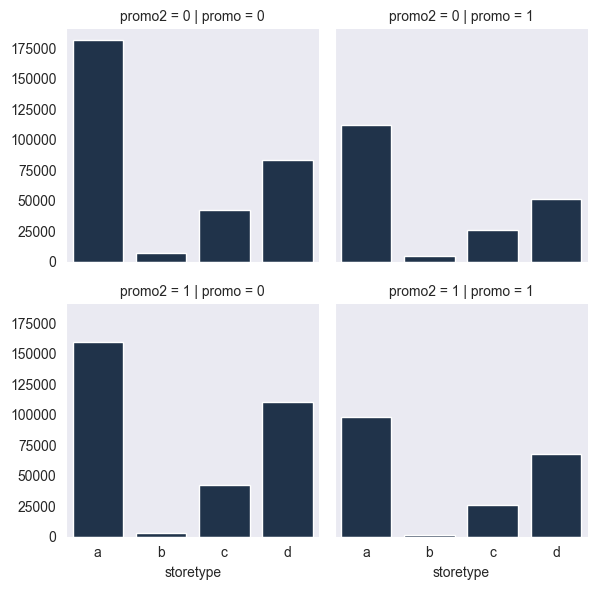

In [122]:
# plotting counts per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df, 
               col = 'promo',
                  row = 'promo2',
               palette = 'plasma',
               #hue = 'assortment',
               )
g.map_dataframe(sns.countplot, "storetype", order=["a","b","c","d"])
g.add_legend()

### Datatype and Encoding of Features